# Сегментация пользователей банка по потреблению банковских продуктов

## Материалы: https://drive.google.com/file/d/1unYDQYgYtEJYVa_O3HLaPz0eReOziCp-/view?usp=sharing

Цель задачи:
Проанализировать клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов. Цель снизить отток клиентов. Предложить продукт который может заинтересовать клиентов в каждой категории. Входе анализа, выполненяются следующие шаги:
    <ul>
    <li> Загрузка данных;</li>
    <li> Предобработка данных;</li>
    <li> Проведение исследовательского анализ данных;</li>
    <li> Сегментация пользователей ;</li>
    <li> Проверка статистических гипотез:</li>
        <ul>
            <li> 1) проверка гипотезы различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним;</li>
            <li> 2) проверка гипотезы различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним;</li>
        </ul>
    <li> Представление выводов и рекомендаций</li>
    </ul>

## Шаг 1. Загрузка данных

In [1]:
#!pip install sparklines

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math as mth
from sklearn.preprocessing import LabelEncoder
from sparklines import sparklines
from scipy.stats import skew, mode
from scipy import stats as st
import random

In [3]:
# Загрузска данных
path_file = 'input/prj_13_input/'
df = pd.read_csv(path_file+'bank_dataset.csv')

In [4]:
df.head(5)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# получение общей информации о данных в таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [6]:
# Изменение стиля написания названий колонок
df.columns= df.columns.str.lower()

In [7]:
# изменим стиль написания колонки creditcard
df.rename(columns={"userid": "user_id","creditcard": "credit_card"}, inplace=True)

In [8]:
# посмотрим на названия колонок после изменения
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

### Описание данных 
* `user_id` — идентификатор пользователя,
* `score` — баллы кредитного скоринга,
* `city` — город,
* `gender` — пол,
* `age` — возраст,
* `objects` — количество объектов в собственности,
* `balance` — баланс на счёте,
* `products` — количество продуктов, которыми пользуется клиент,
* `credit_card` — есть ли кредитная карта,
* `loyalty` — активный клиент,
* `estimated_salary` — заработная плата клиента,
* `churn` — ушёл или нет.

В таблице имеется 10 тыс записей о клиентах банка. Данные описываются характеристиками в 12 колонках. В колонке balance имеется много пропусков. Их необходимо проанализировать и принять решение как их заполнить.

## Шаг 2. Предобработка данных

Изучим данные в колонках с помощью функции, которая описывает тип данных, наличие пропусков и описывает данные.

In [9]:
# Функция для анализа данных в колонках
def data_analysis(column_name):
    """
    Функция описывает данные в колонках таблицы df
    """
    print()
    print('-'*40)
    print(f'Анализ данных в колонке {column_name}')
    print('-'*40)
    print(f'Тип данных в колонке: {df[column_name].dtype}')
    data_0 = len(df[df[column_name].isnull()==True])
    print(f'Количество отсутствующих значений в столбце: {data_0}')
    print(f'Процент отсутствующих значений: {data_0/len(df):.1%}')
    print(f'Число уникальных данных: {len(df[column_name].unique())}')
    if len(df[column_name].unique()) < 40:
        print(f'Уникальные значения: {df[column_name].unique()}')
        if len(df[column_name].unique()) <= 4:
            print('Количество данных по группам уникальных значений:')
            print(df.groupby([column_name])[column_name].count())
    else:
        print('Число уникальных значений слишком велико для вывода')
        
    print('Описание данных в колонке:')
    display(df[column_name].describe()) 

In [10]:
# изучим данные в колонке 'user_id'
data_analysis('user_id')


----------------------------------------
Анализ данных в колонке user_id
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 10000
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count    1.000000e+04
mean     1.573368e+07
std      7.193619e+04
min      1.560844e+07
25%      1.567126e+07
50%      1.573347e+07
75%      1.579597e+07
max      1.585843e+07
Name: user_id, dtype: float64

Данные в колонке userid полные, дубликатов нет

In [11]:
# изучим данные в колонке 'score'
data_analysis('score')


----------------------------------------
Анализ данных в колонке score
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 460
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: score, dtype: float64

Рейтинг заемщика, представленый в таблице, произведен шкале скорингового балла: 300-850. Аномальных значений нет. Пропусков нет.

In [12]:
# изучим данные в колонке 'city'
data_analysis('city')


----------------------------------------
Анализ данных в колонке city
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 3
Уникальные значения: ['Ярославль' 'Рыбинск' 'Ростов Великий']
Количество данных по группам уникальных значений:
city
Ростов Великий    2509
Рыбинск           2477
Ярославль         5014
Name: city, dtype: int64
Описание данных в колонке:


count         10000
unique            3
top       Ярославль
freq           5014
Name: city, dtype: object

В таблице представлены данные для клиентов из 3х городов. Чуть больше половины всех клиентов зарегистрированы в Ярославле (5014 человек), и, практически по ровну (около 2500 человек) зарегистрированно в двух других городах - в Рыбинске и Ростове Великом.

In [13]:
# изучим данные в колонке 'gender'
data_analysis('gender')


----------------------------------------
Анализ данных в колонке gender
----------------------------------------
Тип данных в колонке: object
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: ['Ж' 'М']
Количество данных по группам уникальных значений:
gender
Ж    4543
М    5457
Name: gender, dtype: int64
Описание данных в колонке:


count     10000
unique        2
top           М
freq       5457
Name: gender, dtype: object

Аномальных значений в колонке gender нет. Клиентов мужского пола немного больше (55%), чем клиентов женского пола (45%)

Переведем данные в числовой вид. Т.е зашифруем данные в виде чисел

In [14]:
le = LabelEncoder()

In [15]:
# переведем в числовой вид данные в колонке gender
le.fit(df['gender'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [16]:
# посмотрим соответствие кода и обозначения пола
print(le_name_mapping)

{'Ж': 0, 'М': 1}


In [17]:
# Заменим обозначение пола кодированными данными
df['gender'] = le.transform(df['gender'])

In [18]:
# изучим данные в колонке 'gender' после исправления
data_analysis('gender')


----------------------------------------
Анализ данных в колонке gender
----------------------------------------
Тип данных в колонке: int32
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [0 1]
Количество данных по группам уникальных значений:
gender
0    4543
1    5457
Name: gender, dtype: int64
Описание данных в колонке:


count    10000.000000
mean         0.545700
std          0.497932
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

In [19]:
# изучим данные в колонке 'age'
data_analysis('age')


----------------------------------------
Анализ данных в колонке age
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 70
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

Аномальных значений нет - минимальный возраст 18 лет, максимальный- 92. Средний возраст клиентов -39 лет. Медианное значение возраста - 37 лет.

In [20]:
# изучим данные в колонке 'objects'
data_analysis('objects')


----------------------------------------
Анализ данных в колонке objects
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 11
Уникальные значения: [ 2  1  8  7  4  6  3 10  5  9  0]
Описание данных в колонке:


count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: objects, dtype: float64

Минимальное количество объектов в собственности -0, максимальное - 10. Аномальных значений нет.

In [21]:
# изучим данные в колонке 'balance'
data_analysis('balance')


----------------------------------------
Анализ данных в колонке balance
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 3617
Процент отсутствующих значений: 36.2%
Число уникальных данных: 6382
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64

В данных отсутствуют данные по балансу для 36% пользователей. Минимальный баланс составляет чуть меньше 4 тыс. руб. Максимальный - 250898 руб.

Отсутствующих данных слишком много, чтобы удалить все записи без баланса из таблицы. Заполним пропуски нулями и добавим дополнительную колонку с индикатором баланса: 0 - нет данных, 1- есть данные.

In [22]:
# замена отсутствующих значений нулями
df['balance'] = df['balance'].fillna(0)

In [23]:
# создание колонки с индикатором баланса
df['balance_ind'] = df['balance'].apply(lambda x: 1 if x>0 else 0)

In [24]:
# посмотрим описание данных в колонке balance_ind
df.balance_ind.describe()

count    10000.000000
mean         0.638300
std          0.480517
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: balance_ind, dtype: float64

Посмотрим как распределена величина баланса в зависимости от города регистрации клиента.

<Figure size 1080x432 with 0 Axes>

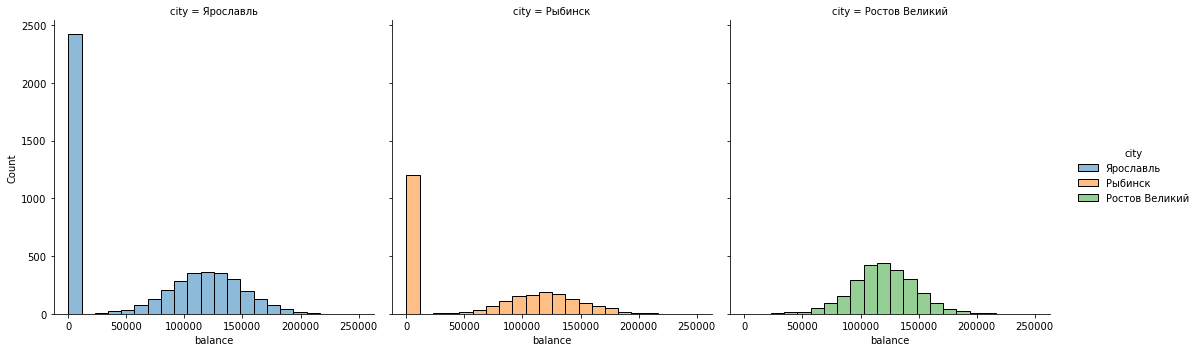

In [25]:
plt.figure(figsize=(15,6))
sns.displot(df, x="balance",col='city', hue='city');

Из графика можно сделать вывод, что в городе Ростов Великий нет клиентов с отсутствующими данными по балансу (нулевой баланс). В целом, распределение баланса имеет вид нормального распределения (если не включать в рассмотрение клиентов с нулевым балансом). Причиной отсутствия данных по балансу в Ярославле и Рыбинске может быть способ регистрации дынных. И этот способ отличается от способа регистрации данных в Ростове Великом.

In [26]:
# изучим данные в колонке 'products'
data_analysis('products')


----------------------------------------
Анализ данных в колонке products
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 4
Уникальные значения: [1 3 2 4]
Количество данных по группам уникальных значений:
products
1    5084
2    4590
3     266
4      60
Name: products, dtype: int64
Описание данных в колонке:


count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: products, dtype: float64

Каждый клиент пользуется продуктами банка. Чуть больше половины клиентов пользуются только одним продуктом. Чуть меньше половины - 2-мя продуктами. Около 300 клиентов из 10 тыс пользуются более чем 2-мя продуктами (3 или 4 продукта).

In [27]:
# изучим данные в колонке 'credit_card'
data_analysis('credit_card')


----------------------------------------
Анализ данных в колонке credit_card
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [1 0]
Количество данных по группам уникальных значений:
credit_card
0    2945
1    7055
Name: credit_card, dtype: int64
Описание данных в колонке:


count    10000.00000
mean         0.70550
std          0.45584
min          0.00000
25%          0.00000
50%          1.00000
75%          1.00000
max          1.00000
Name: credit_card, dtype: float64

Около 70% всех клиентов пользуются кредитными картами. И, соответственно, 30% - не пользуются.

In [28]:
# изучим данные в колонке 'loyalty'
data_analysis('loyalty')


----------------------------------------
Анализ данных в колонке loyalty
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [1 0]
Количество данных по группам уникальных значений:
loyalty
0    4849
1    5151
Name: loyalty, dtype: int64
Описание данных в колонке:


count    10000.000000
mean         0.515100
std          0.499797
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: loyalty, dtype: float64

Практически 52% клиентов является активными клиентами.

In [29]:
# изучим данные в колонке 'estimated_salary'
data_analysis('estimated_salary')


----------------------------------------
Анализ данных в колонке estimated_salary
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 9999
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

Пропусков в данных нет, но есть аномальное значение: минимальное значение заработной платы составляет 11.6 рублей. Проанализируем минимальные величины заработной платы.

Разобьем клиентов банка на категории по величине заработной платы. Так как максимальная заработная плата составляет практически 200 тыс. рублей, а минимальная не сильно отличается от 0, то сделаем 10 категорий с шагом в 20 тыс. Первая категория, это клиетны с заработной платой от 0 до 20 тыс. руб., вторая- от 20 тыс. до 40 тыс. руб., третья - от 40 до 60 тыс. руб. и т.д.

In [30]:
# зададим интревал и шаг разбиения на категории
bins = np.arange(0, 220000, 20000)

In [31]:
# дадим названия категориям
labels = range(1,11)

In [32]:
# добавим колонку с категорией заработной платой клиента 
df['salary_cat'] = pd.cut(df['estimated_salary'], bins=bins, labels=labels)

In [33]:
# проверим тип данных в колонке salary_cat
df['salary_cat'].dtypes

CategoricalDtype(categories=range(1, 11), ordered=True)

In [34]:
# изменим тип данных на int64
df = df.astype({"salary_cat":'int64'}) 

In [35]:
# проверим тип данных после изменений
df['salary_cat'].dtypes

dtype('int64')

In [36]:
# посмотрим на таблицу с новой колонкой
df.head(5)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,balance_ind,salary_cat
0,15677338,619,Ярославль,0,42,2,0.00,1,1,1,101348.88,1,0,6
1,15690047,608,Рыбинск,0,41,1,83807.86,1,0,1,112542.58,0,1,6
2,15662040,502,Ярославль,0,42,8,159660.80,3,1,0,113931.57,1,1,6
3,15744090,699,Ярославль,0,39,1,0.00,2,0,0,93826.63,0,0,5
4,15780624,850,Рыбинск,0,43,2,125510.82,1,1,1,79084.10,0,1,4


Посмотрим как распределено количество клиентов в зависимости от уровня заработных плат. Учтем город клиента.

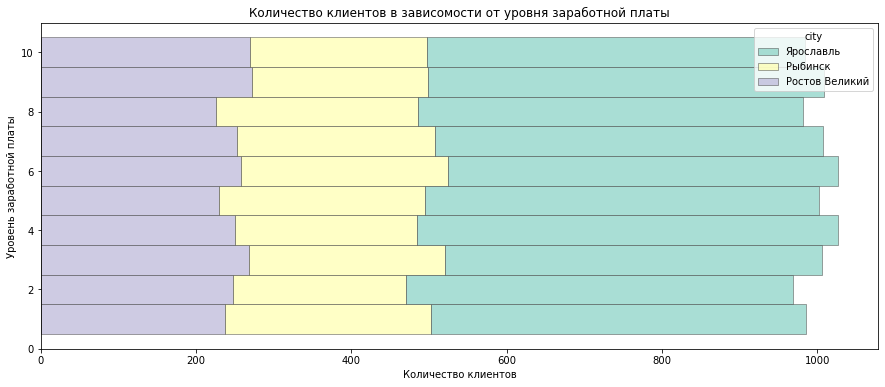

In [37]:
plt.figure(figsize=(15,6))
sns.histplot(
    df,
    y="salary_cat", hue="city",
    multiple="stack",
    palette=("Set3"),
    edgecolor=".3",
    linewidth=.5,
    discrete=True
)
plt.title('Количество клиентов в зависомости от уровня заработной платы')
plt.xlabel('Количество клиентов')
plt.ylabel('Уровень заработной платы');

Ожидание, что распределение по уровню заработной платы будет иметь вид нормального распределения с центром в районе 40-60 тыс. рублей (уровень средней заработной платы в Ярославской области на май 2022 составляет 45 499 руб.) - не оправдалось. По графику мы видим, что в каждой категории заработной платы представлено примерно 10% всех клиентов из таблицы. Т.е распределение - равномерное. Также, мы видим, что распределение количества клиентов банка по уровню заработной платы равномерное для каждого города.

Проверим, есть ли зависимоть баланса на счете от величины заработной платы.

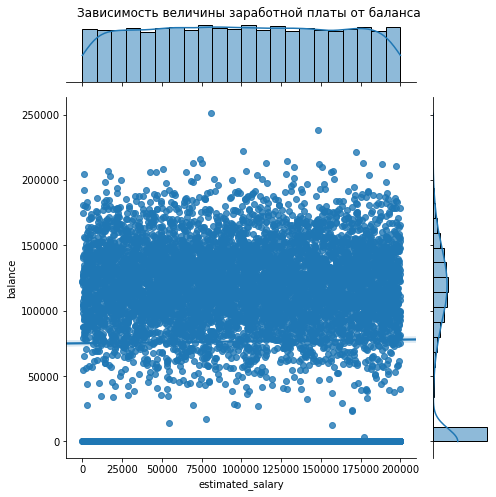

In [38]:
g = sns.jointplot(x="estimated_salary", y="balance", data=df, kind="reg",truncate=False, height=7)
g.fig.suptitle("Зависимость величины заработной платы от баланса")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

Ожидание, что зависимость величины заработной платы от величины баланса на счете - линейная - не оправдалось. Так же, мы не наблюдаем зависимости отсутствия данных по балансу на счете от величины заработной платы.

In [39]:
# изучим данные в колонке 'churn'
data_analysis('churn')


----------------------------------------
Анализ данных в колонке churn
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [1 0]
Количество данных по группам уникальных значений:
churn
0    7963
1    2037
Name: churn, dtype: int64
Описание данных в колонке:


count    10000.000000
mean         0.203700
std          0.402769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: churn, dtype: float64

Все данные в колонках были проверены. Пропуски проанализированны и заполнены. Проверим есть ли дубликаты в таблице, исключая колонку usesr_id

In [40]:
# проверка на отсутствие дубликатов в таблице без учета user_id
print(f"Количество дубликатов в таблице {df.duplicated(subset = ['score', 'city','gender','age','objects','balance','products','credit_card','loyalty','estimated_salary','churn']).sum()}")

Количество дубликатов в таблице 0


In [41]:
df.head(3)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,balance_ind,salary_cat
0,15677338,619,Ярославль,0,42,2,0.00,1,1,1,101348.88,1,0,6
1,15690047,608,Рыбинск,0,41,1,83807.86,1,0,1,112542.58,0,1,6
2,15662040,502,Ярославль,0,42,8,159660.80,3,1,0,113931.57,1,1,6


Удалим колонку user_id , т.к в дальнейшем анализе она не потребуется.

In [42]:
# Иключим столбц salary_cat
df = df.drop(columns=['user_id'])

In [43]:
# посмотрим описание таблицы после всех изменений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   score             10000 non-null  int64  
 1   city              10000 non-null  object 
 2   gender            10000 non-null  int32  
 3   age               10000 non-null  int64  
 4   objects           10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products          10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   loyalty           10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
 11  balance_ind       10000 non-null  int64  
 12  salary_cat        10000 non-null  int64  
dtypes: float64(2), int32(1), int64(9), object(1)
memory usage: 976.7+ KB


Выводы: данные во всех колонках были проверены. Пропуски в колонке balance были заполнены нулями. Все категориальные значения были заменены численными значениями. После всех изменений в таблице осталось 10 тыс строк и 13 колонок с описанием данных.

## Шаг 3. Исследовательский анализ данных

Посмотрим количество клиентов по количеству банковских продуктов

In [44]:
# Построим сводную таблицу для количества пользователей по количеству используемых продуктов
df_pr_nb = df.pivot_table(index='products', values='score',columns='churn', aggfunc='count',fill_value=0)
df_pr_nb = df_pr_nb.reset_index()
df_pr_nb = df_pr_nb.rename_axis(None, axis=1)
df_pr_nb.rename(columns={0: "Не попал в отток",1: "Отток"}, inplace=True)
df_pr_nb

,products,Не попал в отток,Отток
0,1,3675,1409
1,2,4242,348
2,3,46,220
3,4,0,60


Посчитаем процент клиентов в каждой группе потребляемых продуктов и процент оттока

In [45]:
df_pr_nb['Общее количество'] = df_pr_nb["Не попал в отток"] + df_pr_nb["Отток"]
df_pr_nb['Процент клиентов, %'] = (df_pr_nb['Общее количество']*100/df_pr_nb['Общее количество'].sum()).round(decimals =1)
df_pr_nb['Процент оттока, %'] = (df_pr_nb["Отток"]*100/df_pr_nb['Общее количество']).round(decimals =1)
df_pr_nb

,products,Не попал в отток,Отток,Общее количество,"Процент клиентов, %","Процент оттока, %"
0,1,3675,1409,5084,50.8,27.7
1,2,4242,348,4590,45.9,7.6
2,3,46,220,266,2.7,82.7
3,4,0,60,60,0.6,100.0


Построим график распределения клиентов по количеству используемых продуктов.

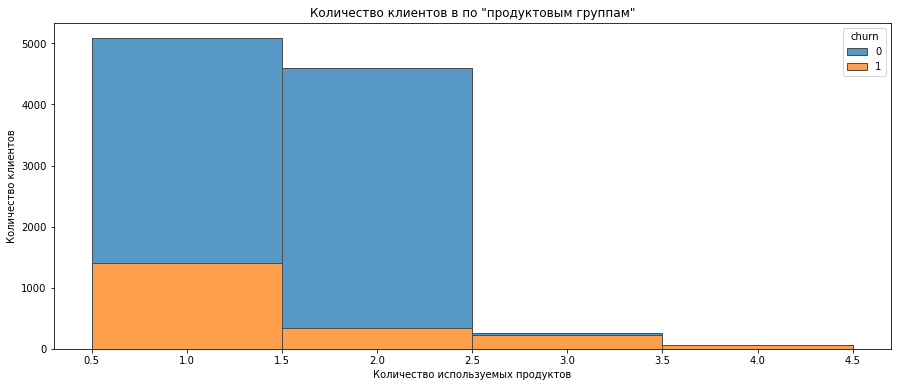

In [46]:
plt.figure(figsize=(15,6))
sns.histplot(
    df,
    x="products", hue="churn",
    multiple="stack",
    edgecolor=".3",
    log_scale=False,
    discrete=True
)
plt.title('Количество клиентов в по "продуктовым группам"')
plt.xlabel('Количество используемых продуктов')
plt.ylabel('Количество клиентов');

Можно выделить 4 продуктовых группы: 
<li> первая группа - клиенты пользуются только одним продуктом. 51% всех клиентов из таблицы df принадлежат к этой группе. Процент оттока в этой группе составляет 28%. </li>
<li> вторая группа - клиенты пользуются двумя продуктами. 46% всех клиентов из таблицы df принадлежат к этой групп. Процент оттока в этой группе составляет 8%.</li>
<li> третья группа - клиенты пользуются тремя продуктами. К этой группе принадлежит только 2.7% клиентов из таблицы df. Процент оттока в этой группе составляет 83%.</li>
<li> четвертая группа - клиенты используют четыре продукта. Это самая малочисленная группа: только 0.6% клиентов из таблицы df входят в нее. Процент оттока в этой группе самый большой - 100%.</li>

Так как третья и четвертая продуктовые группы очень малочисленны, то мы не будем детально изучать характеристики клиентов из этих группы, чтобы понять, что повлияло на их отток. Любое предположение может быть ошибочным из-за малочисленности данных в этих группа. 

Детально будем изучать первую и вторую группы.

Изучим процент оттока в продуктовых группах по городам

In [47]:
df_city = df.pivot_table(index='city',columns='products',values='churn',aggfunc='mean')
df_city = (df_city*100).round(decimals =1)
df_city

products,1,2,3,4
city,,,,
Ростов Великий,42.8,12.1,89.6,100.0
Рыбинск,21.9,7.4,78.8,100.0
Ярославль,22.4,5.7,78.8,100.0


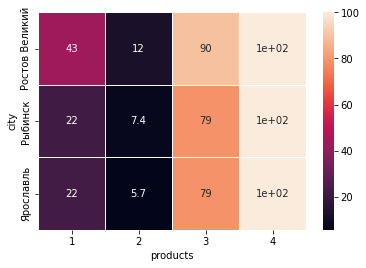

In [48]:
# Построим тепловую мартицу
sns.heatmap(df_city, annot=True, linewidths=.5);

По всем продуктовым группам самый большой отток в Ростове Великом (исключая из рассмотрения 4-ю группу с 100% оттоком).

Определим корреляцию между данными с целью выявления, что больше всего влияет на отток.

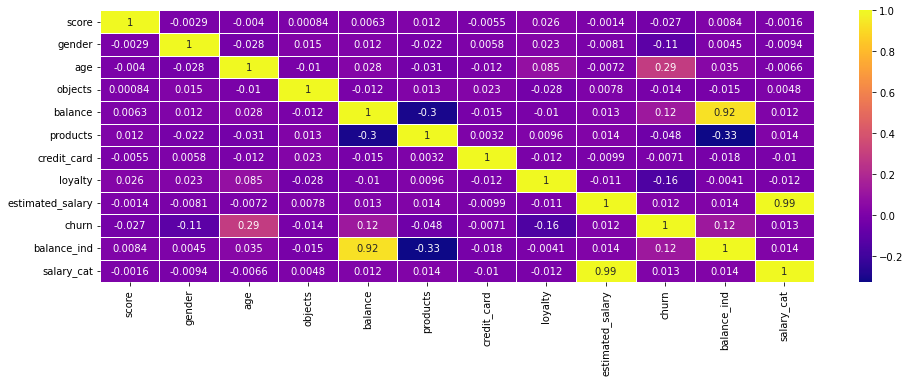

In [49]:
# Построим тепловую мартицу
plt.figure(figsize = (16,5))
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='plasma');

Видно заметную корреляцию оттока с балансом на счету, активностью и возрастом клиентов. Исследуем эти характеристики для каждого города и количества используемых продуктов. Дополнительно исследуем отток среди клиентов мужского и женского пола.

### Изучение баланса на счету и его влияние на отток

Определим процент клиентов, у которых есть данные по балансу на карте.

In [50]:
# сводная таблица по городам
(df.pivot_table(index='city', values='balance_ind', aggfunc='mean')*100).round(decimals =1)

,balance_ind
city,
Ростов Великий,100.0
Рыбинск,51.6
Ярославль,51.8


В Ростове Великом у всех клиентов есть данные по балансу на карте. 48% клиентов в Рыбинске и Ярославле не имеют данных по балансу на счету. Т.е практически у половины клиентов в этих двух городах нет данных по балансу.

Посмотрим какой процент отсутствующих данных по балансу среди продуктовых групп в зависимости от города регистрации клиента.

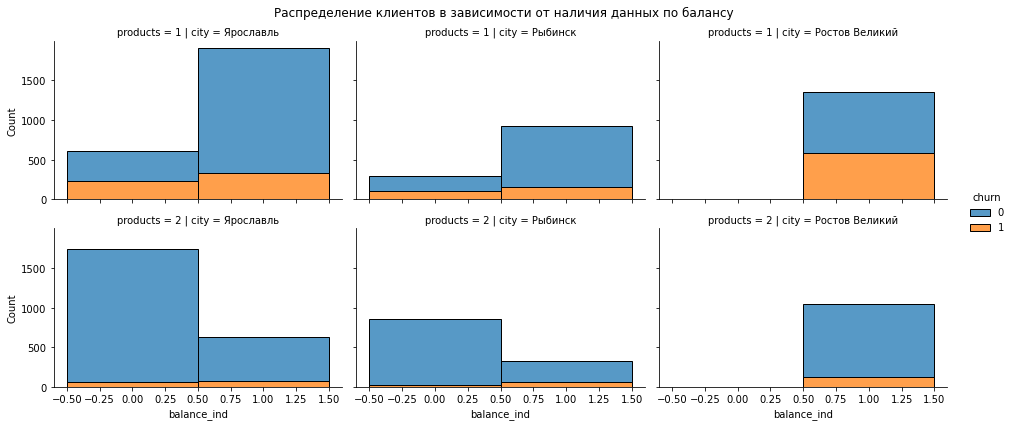

In [51]:
# построим графики распределения количества клиентов по городам и продуктовым группам (1я и 2я) в зависимости от баланса
g= sns.displot(
    df.query('products<3'), 
    x="balance_ind", 
    col="city", 
    row="products",
    hue='churn',
    multiple="stack",
    discrete=True,
    height=3, aspect=1.5
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Распределение клиентов в зависимости от наличия данных по балансу');

Посчитаем процент клиентов с отсутствующими данными по балансу с помощью сводной таблицы

In [52]:
# сводная таблица по городам и продуктовым группам (1 и 2й)
((1-df.query('products<3').pivot_table(index='products', columns='city',values='balance_ind',aggfunc='mean'))*100).round(decimals =1)

city,Ростов Великий,Рыбинск,Ярославль
products,,,
1,0.0,24.2,24.3
2,0.0,72.8,73.5


Видно, что в первой продуктовой группе только 24% клиентов (в Рыбинске и Ярославле) не имеют данных по балансу. Противоположная ситуация во второй продуктовой группе: здесь около 73% клиентов (в Рыбинске и Ярославле) не имеют данные по балансу.

Изучим процент оттока среди клиентов первой и второй продуктовой группы, если данные по балансу НЕ отсутствуют

In [53]:
# сводная таблица по городам и продуктовым группам (1 и 2й)
(df.query('products<3 and balance>0').pivot_table(index='products', columns='city',values='churn',aggfunc='mean')*100).round(decimals =1)

city,Ростов Великий,Рыбинск,Ярославль
products,,,
1,42.8,17.2,17.5
2,12.1,18.9,11.9


Изучим процент оттока среди клиентов первой и второй продуктовой группы, если данные по балансу отсутствуют

In [54]:
# сводная таблица по городам и продуктовым группам (1 и 2й)
(df.query('products<3 and balance==0').pivot_table(index='products', columns='city',values='churn',aggfunc='mean')*100).round(decimals =1)

city,Рыбинск,Ярославль
products,,
1,36.6,37.7
2,3.0,3.5


Можно сделать следующий вывод:
<li> в первой продуктовой группе большая часть клиентов (76% в Рыбинске и Ярославле) имеют данные по балансу на счету. Процент оттока среди этих клиентов (17%) ниже, чем среди клиентов с отсутствующими данными по счету, где процен оттока составляет около 37%. Жители Ростова Великого не имеют отсутствующих данных по балансу на счету и отток здесь составляет 43% </li>
<li> во второй продуктовой группе большая часть клиентов (73% в Рыбинске и Ярославле) НЕ имеют данных по балансу на счету. Процент оттока среди этих клиентов (3%) значительно ниже, чем процент оттока среди клиентов с известным балансом на счету: 12-19% (в зависимости от города регистрации).

Определим среднюю величину баланса на счету по городам и продуктовым группам

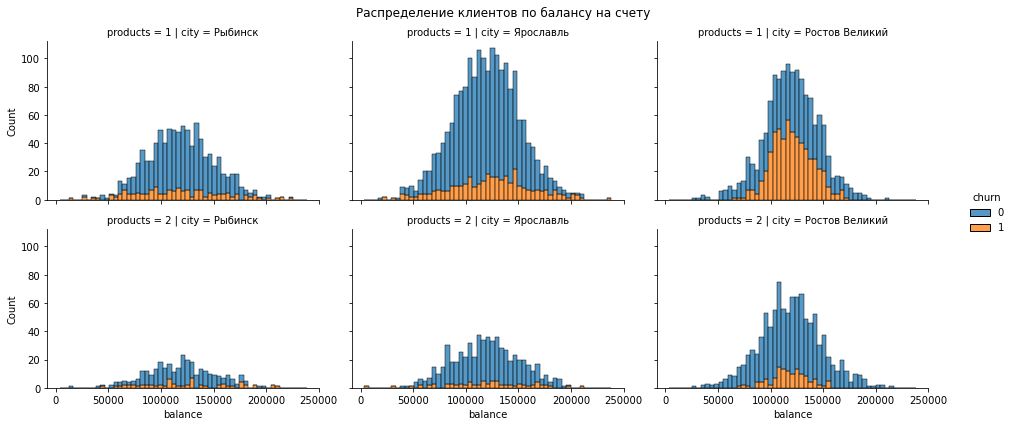

In [55]:
# построим графики распределения величины баланса по продуктовым группам (1я и 2я)
g=sns.displot(
    df.query('products<3 and balance>0'), 
    x="balance", 
    col="city", 
    row="products",
    hue='churn',
    multiple="stack",
    height=3, aspect=1.5
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Распределение клиентов по балансу на счету');

In [56]:
# построим сводную таблицу
(df.query('products<3 and balance>0').pivot_table(index='products', columns='city',values='balance',aggfunc='mean').round())

city,Ростов Великий,Рыбинск,Ярославль
products,,,
1,119868.0,119457.0,120125.0
2,119341.0,120103.0,119964.0


Средняя величина баланса на счету у двух продуктовых групп примерно одинаковая - около 120 тыс. руб.

### Изучение лояльности и возраста клиентов

Посмотрим сколько активных пользователей в каждой продуктовой группе

In [57]:
# сводная таблица по продуктовым группам и активности
df.pivot_table(index='products',values='loyalty',aggfunc='mean')

,loyalty
products,
1,0.504131
2,0.532898
3,0.424812
4,0.483333


В первой продуктовой группе около половины клиентов являются активными пользователями. Чуть выше процент активных клиентов во второй продуктовой группе -53%. Самый низкий процент активности в третей группе - 42%. В четвертой группе 48% клиентов являются активными.

Изучим процент оттока в зависимости от активности клиентов

Построим графики распределения клиентов в зависимости от продуктовых групп (1 и 2), города регистрации и активности клиента.

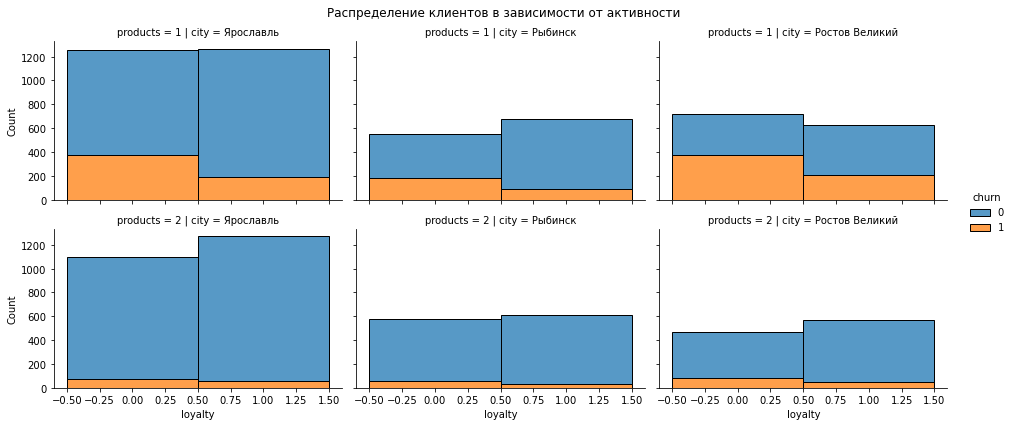

In [58]:
# построим графики для продуктовых групп 1 и 2
g= sns.displot(
    df.query('products<3'), 
    x="loyalty", 
    col="city", 
    row="products",
    hue='churn',
    multiple="stack",
    discrete=True,
    height=3, aspect=1.5
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Распределение клиентов в зависимости от активности');

Посчитаем процент оттока по двум продуктовым группам в разных городах в зависимости от активности клиента.

In [59]:
# сводная таблица по продуктовым группам (1 и 2й)
(df.query('products<3').pivot_table(index='products', columns=['city','loyalty'],values='churn',aggfunc='mean')*100).round(decimals =1)

city     Ростов Великий       Рыбинск       Ярославль      
loyalty               0     1       0     1         0     1
products                                                   
1                  52.1  32.3    32.5  13.2      29.6  15.3
2                  16.5   8.5     9.9   4.9       7.0   4.6

Ожидаемо, что процент оттока выше среди не активных клиентов. Самый высокий процент оттока в первой продуктовой группе среди не активных клиентов в Ростове Великом - более 50% (52%). В этом городе в первой продуктовой группе высокий процент оттока клиентов даже среди активных пользователей - 32%.

Посмотрим как расределены клиенты по возрасту с учетом активности и количества используемых продуктов

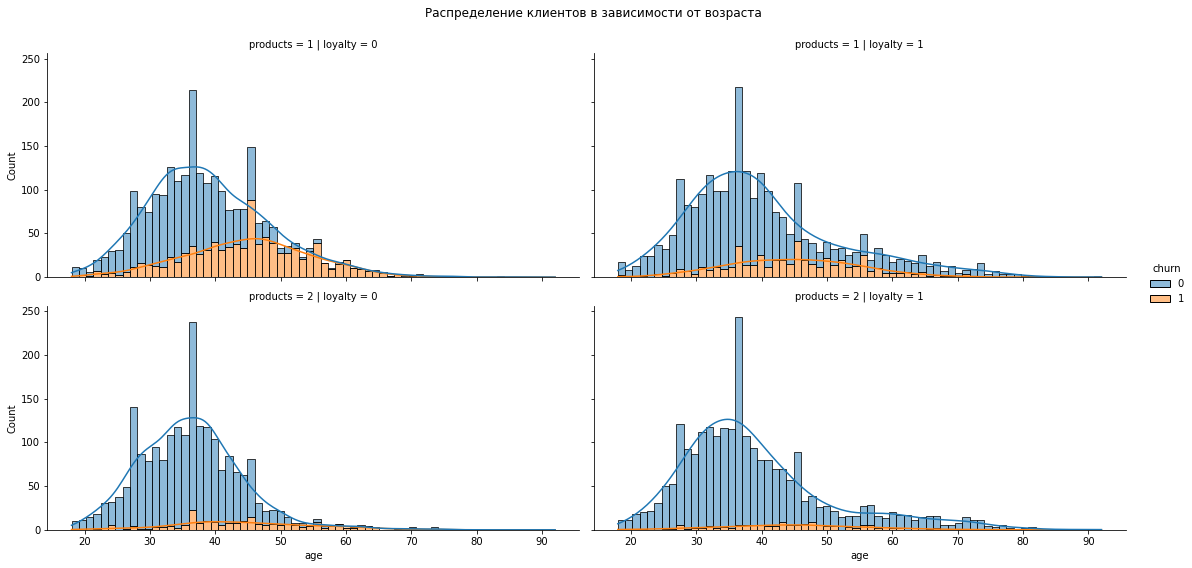

In [60]:
# построим графики распределения по возрасту в продуктовых группах 1 и 2 с учетом активности
g=sns.displot(
    df.query('products<3'), 
    x="age", 
    col="loyalty", 
    row="products",
    hue='churn',
    multiple="stack",
    kde=True,
    height=4, aspect=2
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Распределение клиентов в зависимости от возраста');

Видно, что с увеличением возраста, начиная с 50-60 лет, среди не активных клиентов отток только возрастает. А среди активных клиентов, начиная с пенсионного возраста (50-60 лет) отток снижается.

Посмотрим как меняется процент оттока по возрасту клиентов в зависимости от активности клиента.

In [61]:
# посчитаем процент оттока среди активных и не активных клиентов в 2х продуктовых группах в зависимости от возраста
df_age0 = df.query('products<3 and loyalty==0').groupby('age').churn.agg('mean')
df_age1 = df.query('products<3 and loyalty==1').groupby('age').churn.agg('mean')

In [62]:
# преобразуем данные в датафрейм
df_age0 = df_age0.to_frame()
df_age1 = df_age1.to_frame()
df_age0 = df_age0.reset_index()
df_age1 = df_age1.reset_index()

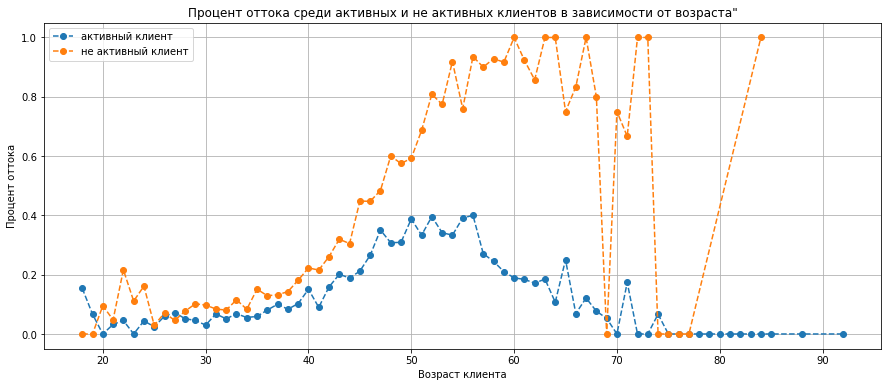

In [63]:
# построение графика
plt.figure(figsize=(15,6))
plt.title('Процент оттока среди активных и не активных клиентов в зависимости от возраста"')
plt.xlabel('Возраст клиента')
plt.ylabel('Процент оттока')
plt.plot(df_age1.age, df_age1.churn, label = "активный клиент",linestyle="--",marker="o")
plt.plot(df_age0.age, df_age0.churn, label = "не активный клиент",linestyle="--",marker="o")
plt.grid()
plt.legend()
plt.show()

Из графика видно, что процент оттока возрастает с увеличением возраста клиента. 

Среди активных клиентов возрастание оттока продолжается до 55 лет, в этом возрасте наблюдается максимальная величина оттока - около 40%. Однако, с увеличением возраста, отток начинает снижаться до 0%. Вероятно, клиенты заключили договор на выплату пенсий через этот банк.

Среди не активных клиентов отток не снижается с увеличением возраста. Отток достигает 100% при возрасте 60 лет. С увеличением возраста мы наблюдаем колебание оттока, но, из-за малочисленности возрастных клиентов, можно принять это колебание за погрешность и принять, что отток остается на уровне 100%.

### Изучение зависимости между полом клиента и оттоком

Посмотрим, кто чаще попадает в отток: мужчины или женщины.

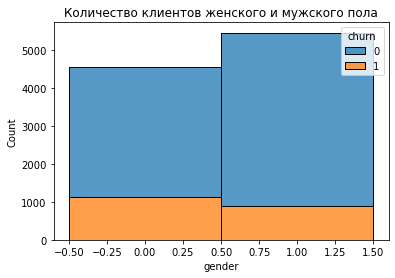

In [64]:
# построим графики распределения количества клиентов в зависимости от пола
sns.histplot(df, x='gender', hue='churn',multiple='stack',discrete=True)
plt.title('Количество клиентов женского и мужского пола');

In [65]:
# подсчитаем процент оттока среди женщин и мужчин
(df.query('products<3').pivot_table(index='products',columns=['gender'],values='churn',aggfunc='mean')*100).round(decimals =1)

gender,0,1
products,,
1,33.2,23.2
2,10.2,5.5


Женщин ("0") меньше чем мужчин ("1") и они чаще попадают в отток.

### Выводы

Клиенты банка используют от одного до 4-х банковских продукта. Самый низкий процент оттока среди клиентов, которые пользуются 2-мя продуктами - 7.6%. Самый высокий процент оттока среди клиентов, которые пользуются 4-мя продуктами - 100%. Однако, группы клиентов, которые пользуются от 3-х до 4-х продуктов малочисленны. Мы не можем делать точный анализ поведения таких клиентов из-за малой выборки. Поэтому, детальный анализ поведения клиентов был сделан только для клиентов, которые используют один или два продукта.

Процент оттока:
<li>среди клиентов, которые пользуются одним продуктом - 28%</li>
<li>среди клиентов, которые пользуются двумя продуктоми - 8%</li>

Из анализа данных было выявленно, что из трех городов, только в Ростове Великом нет клиентов отсутствующими данными по балансу на счету. В двух других городах (Ярославль, Рыбинск) процент клиентов без данных по балансу на счету составляет практически половину от всех клиентов, зарегистрированных в этих городах.

Процент оттока по городам:
<li>среди клиентов, которые пользуются одним продуктом -  Ростов Великий: 43%, Рыбинск: 22%,  Ярославль: 22%.</li>
<li>среди клиентов, которые пользуются двумя продуктоми - Ростов Великий: 12%, Рыбинск: 7%,   Ярославль: 6%.</li>

Зависимость величины баланса (в случае известных данных), размера заработной платы, баллов кредитного скоринга на отток не была выявленна. 

## Сегментация пользователей по количеству продуктов

Разделим всех клиентов на две "продуктовые" группы. Первая группа - пользуется только одним продуктом, вторая - двумя.

Посмотрим медианные значения всех признаков в двух продуктовых группах.

In [66]:
df.query('products<3').pivot_table(index='products',aggfunc='median')

,age,balance,balance_ind,churn,credit_card,estimated_salary,gender,loyalty,objects,salary_cat,score
products,,,,,,,,,,,
1,38,111886.035,1,0,1,99226.830,1,1,5,5,651
2,36,0.000,0,0,1,100738.855,1,1,5,6,653


Можно заметить, что главным отличием одной группы от другой является наличие информации о балансе на счету: в первой группе большая часть клиентов ИМЕЕТ информацию о балансе, во второй группе - большая часть клиентов НЕ имеет информации о балансе на счету.

По остальным характеристикам медианные значения в двух группах отличается не значительно (возраст, заработная плата, скоринговый балл).

Изучим более детально распределение признаков по продуктовым группам. 

Напишем вспомогательные функции для отрисовки sparkline и расчета перцентилей

In [67]:
# функция для вывода sparkline
def sparkline_str(x):
    bins=np.histogram(x)[0]
    sl = ''.join(sparklines(bins))
    return sl
sparkline_str.__name__ = "sparkline"

In [68]:
# функция для расчета перцентиля
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

Запишем список признаков, которые будем изучать

In [69]:
df.columns

Index(['score', 'city', 'gender', 'age', 'objects', 'balance', 'products',
       'credit_card', 'loyalty', 'estimated_salary', 'churn', 'balance_ind',
       'salary_cat'],
      dtype='object')

In [70]:
att_list = ['age','gender','objects', 'balance', 'balance_ind','credit_card','loyalty','estimated_salary']

In [71]:
for i in att_list:
    print(f'Описание признака {i}')
    agg_func_describe = {i: ['mean','median',np.std,percentile(25), percentile(75),sparkline_str]}
    df_i = df.query('products<3').groupby(['products']).agg(agg_func_describe).round(3)
    display(df_i)
    print('')
    print('')

Описание признака age


age                                                       
            mean median     std percentile_25 percentile_75   sparkline
products                                                               
1         39.673   38.0  10.660          32.0          45.0  ▂▅█▅▃▂▁▁▁▁
2         37.754   36.0  10.146          31.0          42.0  ▂▅█▄▂▂▁▁▁▁



Описание признака gender


gender                                                      
           mean median    std percentile_25 percentile_75   sparkline
products                                                             
1         0.548    1.0  0.498           0.0           1.0  ▇▁▁▁▁▁▁▁▁█
2         0.551    1.0  0.497           0.0           1.0  ▇▁▁▁▁▁▁▁▁█



Описание признака objects


objects                                                      
            mean median    std percentile_25 percentile_75   sparkline
products                                                              
1          4.975    5.0  2.914           2.0           7.0  ▁▆▄▅▅▅▅▅▅█
2          5.052    5.0  2.868           3.0           7.0  ▁▅▆▅▅▅▅▅▅█



Описание признака balance


balance                                                     \
               mean      median        std percentile_25 percentile_75   
products                                                                 
1         98551.871  111886.035  53234.093     79700.722    134596.312   
2         51879.146       0.000  62644.475         0.000    113593.458   

                      
           sparkline  
products              
1         ▆▁▂▄██▅▂▁▁  
2         █▁▁▂▂▃▂▂▁▁



Описание признака balance_ind


balance_ind                                                      
                mean median    std percentile_25 percentile_75   sparkline
products                                                                  
1              0.822    1.0  0.383           1.0           1.0  ▃▁▁▁▁▁▁▁▁█
2              0.434    0.0  0.496           0.0           1.0  █▁▁▁▁▁▁▁▁▆



Описание признака credit_card


credit_card                                                      
                mean median    std percentile_25 percentile_75   sparkline
products                                                                  
1              0.704    1.0  0.457           0.0           1.0  ▄▁▁▁▁▁▁▁▁█
2              0.707    1.0  0.455           0.0           1.0  ▄▁▁▁▁▁▁▁▁█



Описание признака loyalty


loyalty                                                      
            mean median    std percentile_25 percentile_75   sparkline
products                                                              
1          0.504    1.0  0.500           0.0           1.0  █▁▁▁▁▁▁▁▁█
2          0.533    1.0  0.499           0.0           1.0  ▇▁▁▁▁▁▁▁▁█



Описание признака estimated_salary


estimated_salary                                                     \
                     mean      median        std percentile_25 percentile_75   
products                                                                       
1               99487.257   99226.830  57363.626     50414.515    148212.695   
2              100452.013  100738.855  57790.800     50797.288    150151.460   

                      
           sparkline  
products              
1         ▃▄▂█▄▆▅▁▃▂  
2         ▃▁█▁▃▄▃▅▅▄

Нормальное распределение имеют две характеристики - 'age' (возраст) и 'balance' (баланс на счету, не учитывая клиентов без данных по балансу). Заработная плата и количество объектов имеют равномерное распределение.

### Выводы

Возраст:
Клиенты первой группы в среденм старше, чем клиенты второй группы:
<li> первая группа: 38 лет (медианное значение)</li>
<li> вторая группа: 36 лет (медианное значение)</li>

Информация о балансе на счету:

<li> первая группа: 82% имеют данные о балансе на счету, т.е клиент первой группы скорее имеет данные о балансе</li>
<li> вторая группа: 43% имеют данные о балансе на счету, т.е клиент второй группы скорее не имеет данных о балансе</li>

Заработная плата:

<li> первая группа: среднее значение 99 500 руб.</li>
<li> вторая группа: среднее значение 100 500 руб.</li>

Величина среденей заработной платы отличается не значительно.

Сформулируем две гипотезы:
<li> Гипотеза 1: заработная плата клиентов первой и второй группы не отличается.</li>
<li> Гипотеза 2: возраст клиентов в первой группе не отличается от возраста клиентов во второй группе </li>

## Проверка статистических гипотез

### Проверка гипотезы равенства заработной платы

Гипотеза: величина заработной платы клиентов в первой группе не отличается от величины заработной платы клиентов во второй группе.

Примем за нулевую гипотезу, что величина заработной платы клиентов в первой группе не отличается от величины заработной платы клиентов во второй группе. Альтернативная гипотеза - величина заработной платы клиентов из первой группы отличается от величины заработной платы во второй группе. Если мы сможем опровергнуть нулевую гипотезу, то величина заработной платы отличается.
Для проверки гипотезы применим  t-тест.

Проверим, что условия применимости t-теста соблюдены : 
<li> генеральные совокупности независимы </li>
<li> выборочные средние нормально распределены </li>
<li> дисперсии рассматриваемых генеральных совокупностей должны быть равны </li>

Величина заработной платы клиентов первой группы не зависит от величины заработной платы клиентов второй группы. Следовательно, выборки (и генеральные совокупности) не зависимы.

Мы знаем, что данные по величине заработной платы распределены равномерно, а не по нормальному закону. Проверим как распределены выборочные средние.

Напишем функцию для создания списка выборочных средних из двух выборок.

In [72]:
def sample_mean_list(df):
    """
    функция для создания списка из 1000 значений выборочных средних из выборки df
    """
    sample_gr_mean = []
    for i in range(0,1000):
        sample_gr_mean.append(df.sample(n=100).mean())
    return sample_gr_mean

Запишем выборки для каждой группы:

In [73]:
df_sample_salary_gr1 = df[df['products']==1]['estimated_salary']
df_sample_salary_gr2 = df[df['products']==2]['estimated_salary']

Посмотрим как распределены выборочные средние в двух выборках

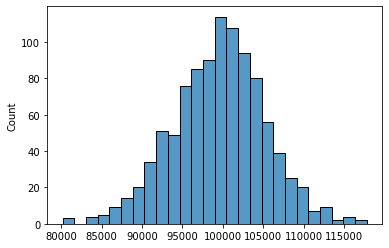

In [74]:
# Распределение выборочных средних из выборки первой группы
sns.histplot(sample_mean_list(df_sample_salary_gr1));

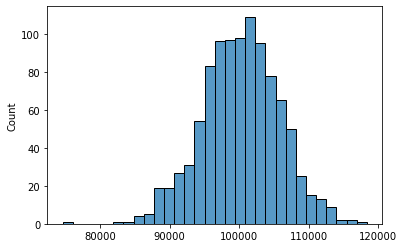

In [75]:
# Распределение выборочных средних из выборки второй группы
sns.histplot(sample_mean_list(df_sample_salary_gr2));

Выборочные средние распределены нормально.

Последние условие применимости t-теста (равенства дисперсий) мы не можем однозначно подтвердить. Хотя величины стандартных отклонений двух выборок очень похожи. Поэтому, проведем t-тест дважды. В первом случае примем, что дисперсии равны (equal_var=True), во втором - нет(equal_var=False). 

Проверим гипотезу, принимая, что дисперсии генеральных совокупностей равны. p-value -примем равным 0.05.

In [76]:
alpha = 0.05

results = st.ttest_ind(
    df_sample_salary_gr1, 
    df_sample_salary_gr2,
    equal_var=True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.41047183624949335
Не получилось отвергнуть нулевую гипотезу


Проверим гипотезу, принимая, что дисперсии генеральных совокупностей НЕ равны

In [77]:
results = st.ttest_ind(
    df_sample_salary_gr1, 
    df_sample_salary_gr2,
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4106493940071987
Не получилось отвергнуть нулевую гипотезу


#### Выводы: 

Величина заработной платы в двух группах не отличается.

### Проверка гипотезы о возрасте клиентов

Гипотеза: возраст клиентов в первой группе не отличается от возраста клиентов во второй группе

Примем за нулевую гипотезу, что возраст клиентов в первой группе не отличается от возраста клиентов во второй группе. Альтернативная гипотеза - возраст клиентов из первой группы отличается от возраста клиентов во второй группе. Если мы сможем опровергнуть нулевую гипотезу, то возраст отличается.
Для проверки гипотезы применим  t-тест.

Выборки независимы, возраст клиентов имеет нормальное распределение. Примем, что дисперсии генеральных совокупностей равны

Запишем выборки возраста клиентов в двух группах

In [78]:
df_sample_age_gr1 = df[df['products']==1]['age']
df_sample_age_gr2 = df[df['products']==2]['age']

In [79]:
results = st.ttest_ind(
    df_sample_age_gr1, 
    df_sample_age_gr2,
    equal_var=True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.730821607368763e-19
Отвергаем нулевую гипотезу


#### Выводы: 

Возраст клиентов двух продуктовых групп отличается.

## Выводы

Клиентов банка можно разделить на три группы по количеству используемых продуктов:

<li> Первая группа использует только один продукт </li>
<li> Вторая группа использует два продукта </li>
<li> Третья групп использует три и более продуктов </li>
<p>
<br>Клиенты первой группы характеризуются более высоким оттоком, чем клиенты второй группы. </br>
<br>Величина заработной платы клиентов в двух группах не отличается.  </br>
<br>Клиенты первой группы немного старше (средний возраст 38 лет), чем клиенты второй группы (средний возраст 36 лет).</br>
<br>Важным отличием двух групп является наличие данных о балансе на счету. Большая часть клиентов первой группы имеет данные о балансе, тогда как большая часть клиентов второй группы - не имеет. </br>
<br>Была выявлена зависимость отсутствия данных по балансу на счету с оттоком. </br>
</p>

<p>
<li> Процент оттока в первой группе - 28%. В зависимости от города регистрации этот процент меняется: в Ярославле и Рыбинске процент оттока составляет 22%, а в Ростове Великом - 43%. 
Из анализа данных было выявлено, что в Ростове Великом самый высокий отток клиентов и в этом городе клиенты не пользуются продуктом, по которому баланс на счете может быть не известен (в отличии от клиентов в Ярославле и Рыбинске). Поэтому, с целью снижения оттока клиентов в Ростове Великом необходимо предложить клиентам продукт, аналогичный продукту в Ярославле и Рыбинске (по которому возможно иметь счет без данных по балансу).</li>

<li> Процент оттока во второй группе составляет 7.6%. Самый высокий процент оттока в Ростове Великом - 12%, самый низкий в Ярославле - 5.7%. Чтобы понизить процент оттока в Ростове Великом, необходимо изучить какими продуктами пользуются в Ярославле и Рыбинске, а именно, понять, какой продукт позволяет иметь счет с отсутствующими данными. Предложение этого продукта клиентам в Ростове Великом поможет снизить процент оттока. </li>

<li> С целью снижения оттока среди клиентов в возрасте от 55-60 лет, необходимо предлагать программу, связанную с выплатой пенсий или пенсионных накоплений. Это позволит удержать в активном статусе клиентов в возрасте от 55 лет и старше, и, следовательно повысить активность и снизить отток.</li>

<li> Самый высокий процент оттока в третьей группе: 83% оттока среди клиентов, которые используют 3 продукта и 100% оттока среди клиентов, которые используют 4 продукта. 
Из-за малочисленности выборки клиентов из третьей группы, детальный анализ характеристик этой группы не был проведен. Однако, можно предложить снизить отток в этой группе путем предложения клиентам уменьшить количество используемых продуктов. Т.е перевести клиентов во вторую или первую группы.</li>
    </p>